<a href="https://colab.research.google.com/github/czkyx/ADE20k_deeplab/blob/main/%E2%80%9CDeepLab_ADE20K_inference_Demo_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This colab demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image. Expected outputs are semantic labels overlayed on the sample image.

### About DeepLab
The models used in this colab perform semantic segmentation. Semantic segmentation models focus on assigning semantic labels, such as sky, person, or car, to multiple objects and stuff in a single image.

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [ ]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the ADE20K dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [ ]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_ade20k_label_colormap():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  colormap = np.asarray([
    [0,0,0],
    [120, 120, 120],
    [180, 120, 120],
    [6, 230, 230],
    [80, 50, 50],
    [4, 200, 3],
    [120, 120, 80],
    [140, 140, 140],
    [204, 5, 255],
    [230, 230, 230],
    [4, 250, 7],
    [224, 5, 255],
    [235, 255, 7],
    [150, 5, 61],
    [120, 120, 70],
    [8, 255, 51],
    [255, 6, 82],
    [143, 255, 140],
    [204, 255, 4],
    [255, 51, 7],
    [204, 70, 3],
    [0, 102, 200],
    [61, 230, 250],
    [255, 6, 51],
    [11, 102, 255],
    [255, 7, 71],
    [255, 9, 224],
    [9, 7, 230],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [7, 255, 224],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [255, 122, 8],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
    [31, 255, 0],
    [255, 31, 0],
    [255, 224, 0],
    [153, 255, 0],
    [0, 0, 255],
    [255, 71, 0],
    [0, 235, 255],
    [0, 173, 255],
    [31, 0, 255],
    [11, 200, 200],
    [255, 82, 0],
    [0, 255, 245],
    [0, 61, 255],
    [0, 255, 112],
    [0, 255, 133],
    [255, 0, 0],
    [255, 163, 0],
    [255, 102, 0],
    [194, 255, 0],
    [0, 143, 255],
    [51, 255, 0],
    [0, 82, 255],
    [0, 255, 41],
    [0, 255, 173],
    [10, 0, 255],
    [173, 255, 0],
    [0, 255, 153],
    [255, 92, 0],
    [255, 0, 255],
    [255, 0, 245],
    [255, 0, 102],
    [255, 173, 0],
    [255, 0, 20],
    [255, 184, 184],
    [0, 31, 255],
    [0, 255, 61],
    [0, 71, 255],
    [255, 0, 204],
    [0, 255, 194],
    [0, 255, 82],
    [0, 10, 255],
    [0, 112, 255],
    [51, 0, 255],
    [0, 194, 255],
    [0, 122, 255],
    [0, 255, 163],
    [255, 153, 0],
    [0, 255, 10],
    [255, 112, 0],
    [143, 255, 0],
    [82, 0, 255],
    [163, 255, 0],
    [255, 235, 0],
    [8, 184, 170],
    [133, 0, 255],
    [0, 255, 92],
    [184, 0, 255],
    [255, 0, 31],
    [0, 184, 255],
    [0, 214, 255],
    [255, 0, 112],
    [92, 255, 0],
    [0, 224, 255],
    [112, 224, 255],
    [70, 184, 160],
    [163, 0, 255],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [255, 0, 143],
    [0, 255, 235],
    [133, 255, 0],
    [255, 0, 235],
    [245, 0, 255],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 41, 255],
    [0, 255, 204],
    [41, 0, 255],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [122, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [0, 133, 255],
    [255, 214, 0],
    [25, 194, 194],
    [102, 255, 0],
    [92, 0, 255],
  ])
  return colormap



def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the ADE20K color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_ade20k_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1]) #分为 1行4列,

  plt.subplot(grid_spec[0])  # 4个图的第一部分
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map) #得到标签对应的数字
  


  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()
  
  #### 统计图片中选择的标签像素占比，比如计算绿色植被占比，此处也可使用collections模块的Counter类：
  size = seg_image.shape[0] * seg_image.shape[1] #  seg_image.shape[1]= 257  ,也等于len(seg_map.flatten())
  selLABEL_NAMES = np.asarray([
                  'tree', 'shrub', 'grass','road','sidewalk','sky','building'
                  ])
  ratio_sum = ratio_plant = 0
  ratio_tree = ratio_shrub = ratio_grass = ratio_road = ratio_sidewalk = 0
  for m in seg_map.flatten():
    label = LABEL_NAMES[m]
    if label == 'tree':
      ratio_tree = ratio_tree+1
    if label == 'shrub':
      ratio_shrub = ratio_shrub+1
    if label == 'grass':
      ratio_grass = ratio_grass+1  
    if label == 'road':
      ratio_road = ratio_road+1 
    if label == 'sidewalk':
      ratio_sidewalk = ratio_sidewalk+1 
     

    for n in selLABEL_NAMES:

      if label == n:
       ratio_sum = ratio_sum + 1
  ratio_tree_i = ratio_tree / len(seg_map.flatten())
  ratio_shrub_i = ratio_shrub / len(seg_map.flatten())
  ratio_grass_i = ratio_grass / len(seg_map.flatten())
  ratio_road_i = ratio_road / len(seg_map.flatten()) 
  ratio_sidewalk_i = ratio_sidewalk / len(seg_map.flatten()) 

  ratio_plant_i = (ratio_tree + ratio_shrub + ratio_grass)/ len(seg_map.flatten())
  #ratio_sum_i = ratio_sum / len(seg_map.flatten())
  print('tree合计占比为：',ratio_tree_i)
  print('shrub合计占比为：',ratio_shrub_i)
  print('grass合计占比为：',ratio_grass_i)
  print('road合计占比为：',ratio_road_i)
  print('sidewalk合计占比为：',ratio_sidewalk_i)

  print('经过计算植物合计占比为：',ratio_plant_i)
  #print('经过计算合计占比为：',ratio_sum_i)
  return ratio_tree_i, ratio_shrub_i, ratio_grass_i, ratio_plant_i, ratio_road_i ,ratio_sidewalk_i


  

LABEL_NAMES = np.asarray([
 'ignore', 'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 
 'bed', 'window', 'grass', 'cabinet', 'sidewalk', 'person', 'ground', 'door', 
 'table', 'mount', 'shrub', 'curtain', 'chair', 'car', 'water', 'picture', 
 'couch', 'shelf', 'house', 'sea', 'mirror', 'rug', 'field', 'armchair',
 'seat', 'fence', 'desk', 'rock', 'clothes', 'lamp', 'bath', 'rail', 'cushion',
 'stand', 'box', 'pillar', 'signboard', 'drawers', 'counter', 'sand', 'sink',
 'skyscraper', 'fireplace', 'refrigerator', 'cupboard', 'path', 'steps',
 'runway', 'case', 'pool', 'pillow', 'screen', 'stairway', 'river', 
 'bridge', 'bookcase', 'blinds', 'coffeeTable', 'toilet', 'flower', 'book',
 'hill', 'bench', 'countertop', 'kitchen Sove', 'tree', 'kitchen', 
 'computingMachine', 'chair', 'boat', 'bar', 'machine', 'hut', 'bus', 
 'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight',
 'booth', 'displayMonitor', 'airplane', 'dirtTrack', 'apparel', 'pole', 
 'ground', 'handrail', 'escalator', 'ottoman', 'bottle', 'counter', 'poster', 
 'stage', 'van', 'ship', 'fountain', 'conveyor', 'canopy', 'washer', 'toy', 
 'swimmingPool', 'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 
 'bike', 'cradle', 'oven', 'ball', 'food', 'step', 'container', 'brandLogo', 
 'oven', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher', 'projectorScreen', 
 'blanket', 'statue', 'hood', 'sconce', 'vase', 'trafficLight', 'tray', 
 'GarbageBin', 'fan', 'dock', 'computerMonitor', 'plate', 'monitoringDevice', 
 'bulletinBoard', 'shower', 'radiator', 'drinkingGlass', 'clock', 'flag'
 ])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
#print('FULL_LABEL_MAP',FULL_LABEL_MAP)

FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
#print('FULL_COLOR_MAP',FULL_COLOR_MAP)



## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [ ]:
MODEL_NAME = 'mobilenetv2_ade20k_train'  # @param ['mobilenetv2_ade20k_train', 'xception65_ade20k_train']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_ade20k_train':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
    'xception65_ade20k_train':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)

# Reduce image size if mobilenet model
if "mobilenetv2" in MODEL_NAME:
  MODEL.INPUT_SIZE = 257

print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image1.jpg?raw=true...


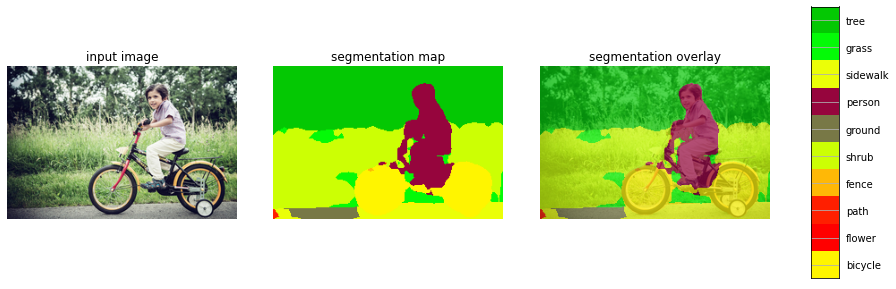

UnboundLocalError: ignored

In [ ]:

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image3.jpg?raw=true...


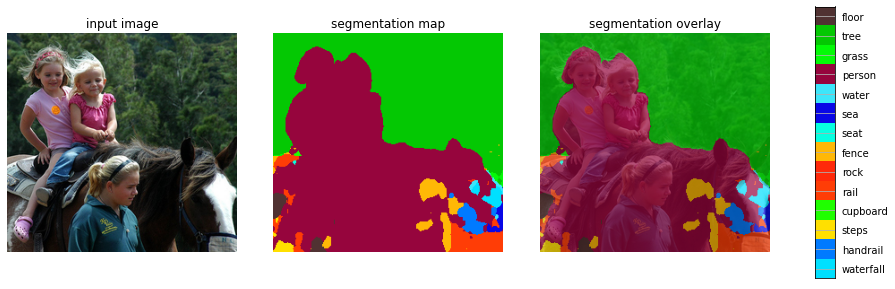

tree合计占比为： 0.3783408815462142
shrub合计占比为： 0.0
grass合计占比为： 0.0017063213625055813
记过计算合计占比为： 0.3800472029087198


In [ ]:

SAMPLE_IMAGE = 'image3'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

读取google drive里的图片文件夹，挂载到 /content/drive/MyDrive/下

In [ ]:
!rm -rf /content/try-pic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/pic/pic.zip" -d "/content/"

Archive:  /content/drive/MyDrive/pic/pic.zip
   creating: /content/try-pic/
  inflating: /content/try-pic/1.png  
  inflating: /content/try-pic/2.png  
  inflating: /content/try-pic/3.jpg  
  inflating: /content/try-pic/4.png  
  inflating: /content/try-pic/5.jpg  


  0%|          | 0/5 [00:00<?, ?it/s]


 running deeplabv3 on image 1.png...


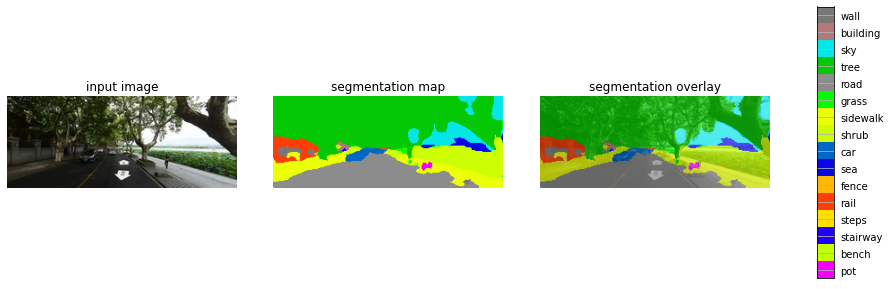

 20%|██        | 1/5 [00:01<00:06,  1.70s/it]

tree合计占比为： 0.4758414869102036
shrub合计占比为： 0.09693626988024631
grass合计占比为： 0.0038910505836575876
road合计占比为： 0.18450379660760832
sidewalk合计占比为： 0.09840958029541763
经过计算植物合计占比为： 0.5766688073741075

 running deeplabv3 on image 2.png...


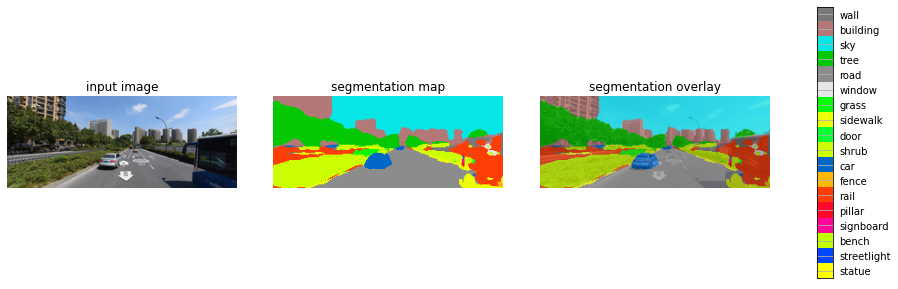

 40%|████      | 2/5 [00:03<00:05,  1.69s/it]

tree合计占比为： 0.14751992746779494
shrub合计占比为： 0.13086018661931925
grass合计占比为： 0.0064598995126742475
road合计占比为： 0.16372634203467945
sidewalk合计占比为： 0.02549960333950361
经过计算植物合计占比为： 0.28484001359978844

 running deeplabv3 on image 3.jpg...


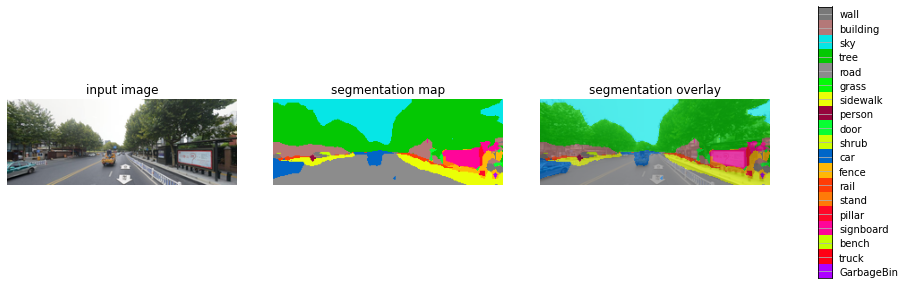

 60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

tree合计占比为： 0.4045071335927367
shrub合计占比为： 8.106355382619974e-05
grass合计占比为： 0.00032425421530479895
road合计占比为： 0.1819471465629053
sidewalk合计占比为： 0.0646887159533074
经过计算植物合计占比为： 0.4049124513618677

 running deeplabv3 on image 4.png...


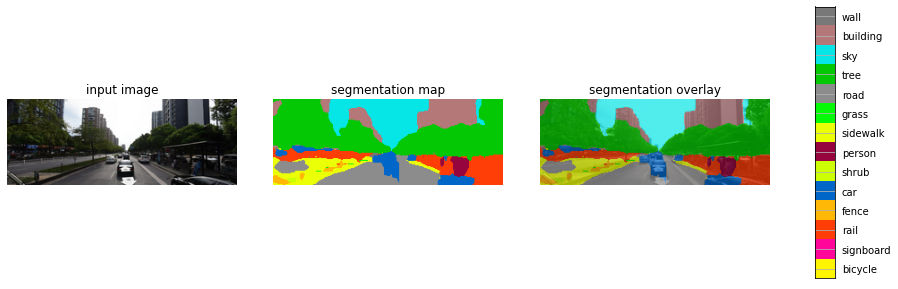

 80%|████████  | 4/5 [00:06<00:01,  1.68s/it]

tree合计占比为： 0.3754863813229572
shrub合计占比为： 0.0022292477302204928
grass合计占比为： 0.0010132944228274968
road合计占比为： 0.11770428015564202
sidewalk合计占比为： 0.06562094682230869
经过计算植物合计占比为： 0.3787289234760052

 running deeplabv3 on image 5.jpg...


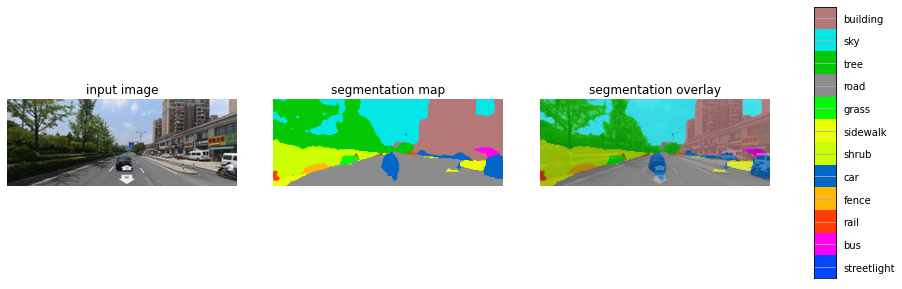

100%|██████████| 5/5 [00:08<00:00,  1.66s/it]

tree合计占比为： 0.21300493401259576
shrub合计占比为： 0.09178065706606763
grass合计占比为： 0.0063781138433150145
road合计占比为： 0.21681575674916764
sidewalk合计占比为： 0.022142885795659675
经过计算植物合计占比为： 0.3111637049219784


In [ ]:
from tqdm import tqdm
import csv
import io
from PIL import Image
test_dir = '/content/pic/'

# ratio_tree_i, ratio_shrub_i, ratio_grass_i, ratio_sum_i = []

with open("/content/test.csv","w",encoding="UTF-8",newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'ratio_tree', 'ratio_shrub', 'ratio_grass', 'ratio_plant', 'ratio_road', 'ratio_sidewalk'])
    path_list = os.listdir(test_dir)
    path_list.sort(key=lambda x:int(x[:-4])) #将'.jpg'左边的字符转换成整数型进行文件名排序
    # print(path_list)
    for m in tqdm(path_list):
      
      pt = os.path.join(test_dir, m)
      with open(pt, 'rb') as f:
        a = f.read() 

      original_im = Image.open(BytesIO(a))
      print('\n running deeplabv3 on image %s...' % m)
      resized_im, seg_map = MODEL.run(original_im)
      ratio_tree_i, ratio_shrub_i, ratio_grass_i, ratio_plant_i, ratio_road_i ,ratio_sidewalk_i = vis_segmentation(resized_im, seg_map)
      writer.writerow([m, ratio_tree_i, ratio_shrub_i, ratio_grass_i, ratio_plant_i, ratio_road_i ,ratio_sidewalk_i])



In [ ]:
test_dir = '/content/pic/'
path_list = os.listdir(test_dir)
path_list.sort(key=lambda x:int(x[:-4])) #将'.jpg'左边的字符转换成整数型进行排序
print(path_list)

['1.png', '2.png', '3.jpg', '4.png', '5.jpg']


In [ ]:
    for m in tqdm(path_list):
      print(m)
      pt = os.path.join(test_dir, m)
      with open(pt, 'rb') as f:
        a = f.read() 
      print(pt)

100%|██████████| 5/5 [00:00<00:00, 150.43it/s]

1.png
/content/pic/1.png
2.png
/content/pic/2.png
3.jpg
/content/pic/3.jpg
4.png
/content/pic/4.png
5.jpg
/content/pic/5.jpg


# 新段落

## What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* For more information on running the DeepLab model on Cloud TPUs, see the [DeepLab tutorial](https://cloud.google.com/tpu/docs/tutorials/deeplab).
